In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
!pip install -U transformers
!pip install -U accelerate
!pip install -U datasets
!pip install -U bertviz
!pip install -U umap-learn
!pip install -U sentencepiece
!pip install -U urllib3
!pip install py7zr
!pip install evaluate
!pip install rouge_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 86.6 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: botocore
    Found existing installation: botocore 1.35.16
    Uninstalling botocore-1.35.16:
      Successfully uninstalled botocore-1.35.16
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.15.0 requires botocore<1.35.17,>=1.35.16, but you have botocore 1.29.165 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.3/126.3 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.18
    Uninstalling urllib3-1.26.18:
      Successfully uninstalle

In [3]:
from datasets import load_dataset
from transformers import pipeline

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch

In [4]:
device = 'gpu'
model_ckpt = 'google-t5/t5-small'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [5]:
xsum = load_dataset('stacked-summaries/onlystacked-xsum-1024')
xsum

README.md:   0%|          | 0.00/2.53k [00:00<?, ?B/s]

(…)-00000-of-00001-61cd2e5b57e014fd.parquet:   0%|          | 0.00/282M [00:00<?, ?B/s]

(…)-00000-of-00001-882532fcd4e39e7c.parquet:   0%|          | 0.00/15.9M [00:00<?, ?B/s]

(…)-00000-of-00001-179f84fb077948d0.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/116994 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6603 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6499 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id', 'chapter_length', 'summary_length', 'is_stacked'],
        num_rows: 116994
    })
    validation: Dataset({
        features: ['document', 'summary', 'id', 'chapter_length', 'summary_length', 'is_stacked'],
        num_rows: 6603
    })
    test: Dataset({
        features: ['document', 'summary', 'id', 'chapter_length', 'summary_length', 'is_stacked'],
        num_rows: 6499
    })
})

In [6]:
xsum['train'] = xsum['train'].select(range(40_000))
xsum['validation'] = xsum['validation'].select(range(2000))

In [7]:
xsum = xsum.remove_columns(['id', 'chapter_length', 'summary_length', 'is_stacked'])

In [8]:
xsum = xsum.filter(lambda x : x['document'] is not None)
xsum = xsum.filter(lambda x : x['summary'] is not None)

Filter:   0%|          | 0/40000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6499 [00:00<?, ? examples/s]

Filter:   0%|          | 0/40000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6499 [00:00<?, ? examples/s]

In [9]:
xsum

DatasetDict({
    train: Dataset({
        features: ['document', 'summary'],
        num_rows: 40000
    })
    validation: Dataset({
        features: ['document', 'summary'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['document', 'summary'],
        num_rows: 6499
    })
})

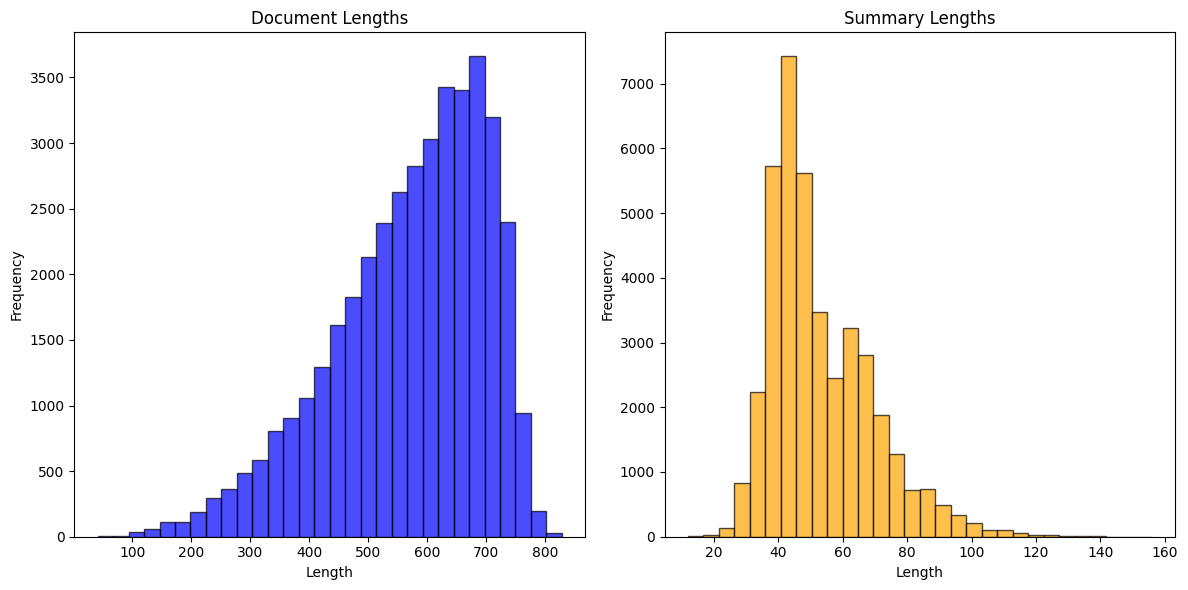

In [10]:
import matplotlib.pyplot as plt

doc_len = [len(i['document'].split()) for i in xsum['train']]
sum_len = [len(i['summary'].split()) for i in xsum['train']]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

axs[0].hist(doc_len, bins=30, color='blue', edgecolor='black', alpha=0.7)
axs[0].set_title('Document Lengths')
axs[0].set_xlabel('Length')
axs[0].set_ylabel('Frequency')

# Histogram for summary lengths
axs[1].hist(sum_len, bins=30, color='orange', edgecolor='black', alpha=0.7)
axs[1].set_title('Summary Lengths')
axs[1].set_xlabel('Length')
axs[1].set_ylabel('Frequency')

plt.tight_layout()


In [11]:
def preprocessing(batch):
    encodings = tokenizer(batch['document'], text_target=batch['summary'],
                        max_length=1024, truncation=True)

    encodings = {'input_ids': encodings['input_ids'],
               'attention_mask': encodings['attention_mask'],
               'labels': encodings['labels']}

    return encodings


xsum_pt = xsum.map(preprocessing, batched=True, remove_columns = ['document', 'summary'])

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/6499 [00:00<?, ? examples/s]

In [12]:
xsum_pt

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 40000
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 6499
    })
})

In [13]:
from transformers import DataCollatorForSeq2Seq
from evaluate import load
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [14]:
from evaluate import load
import rouge_score

# Load the ROUGE metric only once
rouge = load("rouge")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    
    # Convert logits to predicted token IDs
    predictions = np.argmax(logits, axis=-1)  # Adjust if necessary
    # Decode predictions and labels to text
    decoded_predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_references = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Compute ROUGE scores
    results = rouge.compute(predictions=decoded_predictions, references=decoded_references)

    # Optionally format results to return specific ROUGE scores
    return {key: value.mid.fmeasure * 100 for key, value in results.items()}


In [18]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir = 'tf_xsum',
    num_train_epochs=1,
    warmup_steps = 200,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay = 0.01,
    logging_steps = 10,
    evaluation_strategy = 'steps',
    eval_steps=100,
    save_steps=1e6,
    gradient_accumulation_steps=16,
    fp16 = True
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [19]:
trainer = Trainer(model=model, args=training_args, tokenizer=tokenizer, data_collator=data_collator,
                  train_dataset = xsum_pt['train'], eval_dataset = xsum_pt['validation'])

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [20]:
trainer.train()

Step,Training Loss,Validation Loss
100,3.095100,2.758671
200,2.675500,2.406473
300,2.604900,2.349770


TrainOutput(global_step=312, training_loss=3.081287200634296, metrics={'train_runtime': 2300.0263, 'train_samples_per_second': 17.391, 'train_steps_per_second': 0.136, 'total_flos': 1.03706712735744e+16, 'train_loss': 3.081287200634296, 'epoch': 0.9984})

In [21]:
trainer.save_model('t5_model')

In [16]:
!zip bart_samsum.zip -r bart_samsum_model/

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  adding: bart_samsum_model/ (stored 0%)
  adding: bart_samsum_model/tokenizer_config.json (deflated 75%)
  adding: bart_samsum_model/generation_config.json (deflated 48%)
  adding: bart_samsum_model/merges.txt (deflated 53%)
  adding: bart_samsum_model/training_args.bin (deflated 51%)
  adding: bart_samsum_model/vocab.json (deflated 59%)
  adding: bart_samsum_model/special_tokens_map.json (deflated 52%)
  adding: bart_samsum_model/config.json (deflated 61%)
  adding: bart_samsum_model/tokenizer.json (deflated 72%)
  adding: bart_samsum_model/model.safetensors (deflated 7%)


In [17]:
from transformers import pipeline

In [24]:

pipe = pipeline('summarization', model='t5_model', device = 0)
gen_kwargs = {'length_penalty': 0.8, 'num_beams': 8, "max_length": 128}

In [26]:
custom_dialogue="""

The rapid advancement of technology has significantly transformed the way we communicate and interact with each other. With the rise of smartphones and social media platforms, people can now share information instantaneously, bridging geographical gaps and fostering global connections. However, this digital revolution has also led to concerns about privacy, mental health, and the impact of misinformation. As we navigate this evolving landscape, it is crucial to find a balance between embracing innovation and addressing the potential challenges that come with it.

"""
print(pipe(custom_dialogue, **gen_kwargs))

Your max_length is set to 128, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)


[{'summary_text': 'the rapid advancement of technology has transformed the way we communicate and interact with each other . this digital revolution has led to concerns about privacy, mental health, and misinformation .'}]


In [1]:
import torch
print(torch.__version__)


2.4.0+cpu
